## Library Setup

## Transformations
 - <mark>__Scale Down Ordinal Data By Substracting all samples with Global Feature Minimum__</mark>
 - <mark>__Sort Columns by Name for better visibility__</mark>
 - <mark>__Ordinally Encode Nominal Data to reduce categorical distance within a feature__</mark>
 - <mark>__Add a Column - Sum of all Binary Features along x-axis__</mark>
 - <mark>__Standardise the Ratio Features using MinMaxScaler__</mark>
 - <mark>__Group By binary Literal__</mark>
 - <mark>__Generate Ordinal Values L2 Norm__</mark>


In [1]:
import os

import warnings
from sklearnex import patch_sklearn
import numpy as np
import pandas as pd
from category_encoders import (
    BackwardDifferenceEncoder,
    BaseNEncoder,
    BinaryEncoder,
    CatBoostEncoder,
    CountEncoder,
    GLMMEncoder,
    HelmertEncoder,
    JamesSteinEncoder,
    LeaveOneOutEncoder,
    MEstimateEncoder,
    SummaryEncoder,
    TargetEncoder,
    WOEEncoder,
)
from sklearn import set_config
from sklearn.base import clone as model_clone
from sklearn.cluster import *
from sklearn.compose import *
from sklearn.cross_decomposition import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.gaussian_process import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.multioutput import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.utils import *
from sklearn.dummy import *
from sklearn.semi_supervised import *
from sklearn.discriminant_analysis import *
from sklearn.covariance import *
from collections import Counter
import sklearn
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.calibration import *
import joblib

pd.options.display.max_columns = 50
set_config(display="diagram")
warnings.filterwarnings("ignore")
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import ADASYN,SMOTE,RandomOverSampler,SVMSMOTE,SMOTENC,SMOTEN,BorderlineSMOTE,KMeansSMOTE

plt.style.use('fivethirtyeight')

%matplotlib inline
import seaborn as sns

sns.set()
from joblib import parallel_backend
from joblib.memory import Memory

patch_sklearn()
def allow_stopping(func):
    def wrapper():
        try:
            value = func()
            return value
            # gc.collect()
        except KeyboardInterrupt as e:
            print("Program Stopped")
        gc.collect()

    return wrapper


import warnings

warnings.filterwarnings("ignore")

__refresh__ = 1


def run_if_refresh(func):
    def wrapper():
        global __refresh__
        if __refresh__ == 1:
            value = func()
            return value
        else:
            print(
                "Using Cache, Set Refresh to '__refresh__=1' to regenerate "
                "the output of this  function"
            )

    return wrapper


def gen_train_test(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=10
    )
    return X_train, X_test, y_train, y_test


def categorise_input(X: pd.DataFrame):
    X.loc[:, nominal + ordinal] = X.loc[:, nominal + ordinal].astype("category")
    return X

KAGGLE_ENV = 1
cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd:
    KAGGLE_ENV = 0
    
if KAGGLE_ENV==1:
    
    categoriser = FunctionTransformer(categorise_input, feature_names_out="one-to-one")
categoriser = FunctionTransformer(categorise_input, feature_names_out="one-to-one")


def quick_test(X):
    clfs = [
        RandomForestClassifier(class_weight="balanced_subsample", random_state=42),
        DecisionTreeClassifier(class_weight="balanced", random_state=42),
        HistGradientBoostingClassifier(random_state=42),
        LogisticRegressionCV(max_iter=1000, class_weight="balanced", random_state=42),
    ]
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.5)
    for clf in clfs:
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        score = f1_score(y_test, y_pred, average="macro")
        print(f"{clf.__class__.__name__} :: {score}")


def find_correlated_features(df, threshold=0.8):
    correlated_features = set()
    correlation_matrix = df.corr()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    return list(correlated_features)

        
"""
PCA MCA Equivalent
"""

# df = raw_data
def MCA(df):
    tmp_nom = np.zeros(df.shape[0])
    for c in df.columns:
        nom_f = df[c]
        nom_f_vc = nom_f.value_counts()    
        nom_f_ohe = pd.get_dummies(nom_f)
        nom_f_vc_pk = nom_f_vc/df.shape[0]
        for ci in nom_f_ohe.columns:
            nom_f_ohe[ci] = (nom_f_ohe[ci]/nom_f_vc_pk[ci])-1
        tmp_nom = np.c_[tmp_nom,nom_f_ohe.to_numpy()]
        # break
    final_tmp_nom = tmp_nom[:,1:]
    dime = PCA(svd_solver='full',)
    final_nome_t  = dime.fit_transform(final_tmp_nom)
    return final_nome_t

        
"""
Binary Target Distributions
"""

def binary_target_dist(df):
    bin_target_0 = pd.DataFrame(columns=binary, index=[0,1,2])
    bin_target_1 = pd.DataFrame(columns=binary, index=[0,1,2])
    for c in binary:
        target_census = df.target.value_counts().to_dict()    
        f = df.groupby([c])['target'].value_counts().sort_index().unstack().transpose()
        # print(f[0])
        bin_target_0[c] = f[0]
        bin_target_1[c] = f[1]
    for i in range(3):
        bin_target_0.loc[i,:] = bin_target_0.loc[i,:] / target_census[i]
        bin_target_1.loc[i,:] = bin_target_1.loc[i,:] / target_census[i]
    return bin_target_0, bin_target_1

def m_VI(df):
    VI = np.linalg.inv(np.cov(df, rowvar=False))
    return VI

class ColumnSelectors:
    def __init__(self, default=None):
        self.dtype_info = {
            "binary__v_1": "Binary",
            "binary__v_11": "Binary",
            "binary__v_14": "Binary",
            "binary__v_26": "Binary",
            "binary__v_27": "Binary",
            "binary__v_28": "Binary",
            "binary__v_30": "Binary",
            "binary__v_9": "Binary",
            "nominal__v_12": "Nominal",
            "nominal__v_18": "Nominal",
            "nominal__v_20": "Nominal",
            "nominal__v_21": "Nominal",
            "nominal__v_25": "Nominal",
            "nominal__v_3": "Nominal",
            "nominal__v_32": "Nominal",
            "nominal__v_4": "Nominal",
            "ordinal__v_0": "Ordinal",
            "ordinal__v_10": "Ordinal",
            "ordinal__v_13": "Ordinal",
            "ordinal__v_15": "Ordinal",
            "ordinal__v_17": "Ordinal",
            "ordinal__v_19": "Ordinal",
            "ordinal__v_22": "Ordinal",
            "ordinal__v_23": "Ordinal",
            "ordinal__v_24": "Ordinal",
            "ordinal__v_29": "Ordinal",
            "ordinal__v_31": "Ordinal",
            "ordinal__v_33": "Ordinal",
            "ordinal__v_5": "Ordinal",
            "ordinal__v_6": "Ordinal",
            "ratio__v_16": "Ratio",
            "ratio__v_2": "Ratio",
            "ratio__v_34": "Ratio",
            "ratio__v_35": "Ratio",
            "ratio__v_36": "Ratio",
            "ratio__v_37": "Ratio",
            "ratio__v_38": "Ratio",
            "ratio__v_39": "Ratio",
            "ratio__v_40": "Ratio",
            "ratio__v_7": "Ratio",
            "ratio__v_8": "Ratio",
        }

        self.ordinal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Ordinal"
        ]
        self.nominal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Nominal"
        ]
        self.binary_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Binary"
        ]
        self.ratio_cols = [i for i in self.dtype_info if self.dtype_info[i] == "Ratio"]
        self.ordinal = make_column_selector(
            pattern="|".join(self.ordinal_cols),
        )
        self.nominal = make_column_selector(
            pattern="|".join(self.nominal_cols),
        )
        self.binary = make_column_selector(
            pattern="|".join(self.binary_cols),
        )
        self.ratio = make_column_selector(
            pattern="|".join(self.ratio_cols),
        )

    def ordinal_selector(self):
        return self.ordinal

    def nominal_selector(self):
        return self.nominal

    def binary_selector(self):
        return self.binary

    def ratio_selector(self):
        return self.ratio

    def categorise_data(self, df: pd.DataFrame = None):
        """
        Categorise Data based on given data
        :params df : pandas.Dataframe
        """
        if isinstance(df, pd.DataFrame):
            ordinal_data = df.loc[:, self.ordinal_cols]
            nominal_data = df.loc[:, self.nominal_cols]
            binary_data = df.loc[:, self.binary_cols]
            ratio_data = df.loc[:, self.ratio_cols]
        else:
            print("Please provide valid Data")
        return ordinal_data, nominal_data, binary_data, ratio_data


column_directory = ColumnSelectors()

DATA_PATH = "/kaggle/input/students-drop-out-prediction/"
DATA_SAVE_PATH = "/kaggle/working/"
TRAIN_DATA = "train.csv"
TEST_DATA = "test.csv"
KAGGLE_ENV = 1
BENCHMARK_INPUT = '/kaggle/input/sub-sample/'
cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd or "u164131" in cwd:
    KAGGLE_ENV = 0

if KAGGLE_ENV == 0:
    LOCAL_PATH = "../data"
    DATA_PATH = LOCAL_PATH + DATA_PATH
    DATA_SAVE_PATH = LOCAL_PATH + DATA_SAVE_PATH
    BENCHMARK_INPUT = LOCAL_PATH + BENCHMARK_INPUT

CACHE_ = Memory(DATA_SAVE_PATH,verbose=0)

def write_raw_data(raw_data: pd.DataFrame, raw_data_eval: pd.DataFrame):
    global DATA_SAVE_PATH
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")


# TODO rerun this script to rename the target column


def reload_raw_data():
    global DATA_SAVE_PATH
    raw_data = pd.read_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval = pd.read_parquet(DATA_SAVE_PATH + "test.parquet")
    return raw_data, raw_data_eval

benchmark = pd.read_csv(BENCHMARK_INPUT+'sample.csv')

def make_submission(y):
    trial=0
    y_df = pd.DataFrame(y, columns=["label"])
    y_df.index.rename('id',inplace=True)
    y_df.to_csv(
        DATA_SAVE_PATH + "submission.csv",
    )
    if trial==0:
        benchmark.to_csv(DATA_SAVE_PATH+ "submission.csv")

@run_if_refresh
def rename_columns_with_dtype(DATA_PATH=DATA_PATH, DATA_SAVE_PATH=DATA_SAVE_PATH):
    raw_data = pd.read_csv(DATA_PATH + TRAIN_DATA, index_col=0)
    raw_data_eval = pd.read_csv(DATA_PATH + TEST_DATA, index_col=0)

    raw_dtypes_info = {}
    saved_dtypes_info = column_directory.dtype_info
    for k, v in saved_dtypes_info.items():
        tmp = k.split("__")
        data_type = tmp[0]
        column_name = tmp[1]
        raw_dtypes_info[column_name] = k

    raw_data.rename(columns=raw_dtypes_info, inplace=True)
    raw_data_eval.rename(columns=raw_dtypes_info, inplace=True)
    raw_data.rename(columns={"label": "target"}, inplace=True)
    write_raw_data(raw_data, raw_data_eval)
    return raw_data, raw_data_eval


# rename_columns_with_dtype()
def reset_data():
    return rename_columns_with_dtype()
    

raw_data, raw_data_eval = reset_data()

X = raw_data.drop(["target"], axis=1)
y = raw_data.target

ordinal = column_directory.ordinal_cols
nominal = column_directory.nominal_cols
binary = column_directory.binary_cols
ratios = column_directory.ratio_cols

ordinal_data, nominal_data, binary_data, ratios_data = column_directory.categorise_data(
    raw_data
)
(
    ordinal_data_eval,
    nominal_data_eval,
    binary_data_eval,
    ratios_data_eval,
) = column_directory.categorise_data(raw_data_eval)

def baseline(raw_data=raw_data, test_size=0.5):
    X = raw_data.drop(["target"], axis=1)
    y = raw_data.target
    # quick_test(X)
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=test_size)

    random_forest = BalancedRandomForestClassifier(random_state=10)
    tmp_clf = make_pipeline(
        RFE(
            estimator=BalancedRandomForestClassifier(random_state=42),
            n_features_to_select=50,
        ),
        AdaBoostClassifier(
            base_estimator=random_forest, n_estimators=4, random_state=10
        ),
    )
    with parallel_backend("loky"):
        y_pred = tmp_clf.fit(X_train, y_train).predict(X_test)
        print(classification_report(y_test, y_pred))
        scores = cross_validate(
            tmp_clf,
            X,
            y,
            cv=StratifiedKFold(n_splits=4),
            n_jobs=-1,
            scoring="f1_macro",
            return_train_score=True,
        )
        print("F1_Train", scores["train_score"].mean())
        print("F1_Test", scores["test_score"].mean())


# baseline()

__refresh__ = 1
raw_data, raw_data_eval = reset_data()
def gen_categorical_mask(df):
    categorical_f_mask =[]
    # X = raw_data.columns
    for f in df.columns:
        if f in ordinal+nominal+binary:
            categorical_f_mask.append(True)
        else:
            categorical_f_mask.append(False)
    return categorical_f_mask
# @run_if_refresh
def update_ordinal_data(raw_data=raw_data, raw_data_eval=raw_data_eval):
    categorical_columns = [ordinal, nominal]
    ordinal_data = raw_data.loc[:, ordinal].copy()
    ordinal_data_eval = raw_data_eval.loc[:, ordinal].copy()
    raw_data.loc[:, ordinal] = ordinal_data - ordinal_data.min()
    raw_data_eval.loc[:, ordinal] = ordinal_data_eval - ordinal_data.min()
    # update_categorical_data()
    # disp = raw_data.loc[:, ordinal].min().plot(color="r", rot=90)
    # disp = raw_data_eval.loc[:, ordinal].min().plot(rot=90)
    # write_raw_data(raw_data, raw_data_eval)
    return raw_data, raw_data_eval

# @run_if_refresh
def sort_columns_by_name(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data = raw_data.sort_index(axis=1)
    raw_data_eval = raw_data_eval.sort_index(axis=1)
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")
    return raw_data, raw_data_eval

# @run_if_refresh
def ordinally_encode_nominal_data(raw_data=raw_data, raw_data_eval=raw_data_eval):
    ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=125)
    nominal_enc_data = ordinal_enc.fit_transform(raw_data.loc[:, nominal])
    nominal_enc_data_eval = ordinal_enc.transform(raw_data_eval.loc[:, nominal])
    raw_data.loc[:, nominal] = nominal_enc_data
    raw_data_eval.loc[:, nominal] = nominal_enc_data_eval
    # write_raw_data(raw_data, raw_data_eval)
    return raw_data, raw_data_eval
# @run_if_refresh
def binary_feature_sum(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data["binary_sum"] = raw_data.loc[:, binary].sum(axis=1)/7
    raw_data_eval["binary_sum"] = raw_data_eval.loc[:, binary].sum(axis=1)/7
    # write_raw_data(raw_data, raw_data_eval)
    return raw_data, raw_data_eval

# @run_if_refresh
def standardise_ratio_features(
    raw_data=raw_data.copy(), raw_data_eval=raw_data_eval.copy()
):
    # Load Data
    payload = raw_data.loc[:, ratios]
    payload_eval = raw_data_eval.loc[:, ratios]
    mscaler = MinMaxScaler()
    # Apply Scaling
    payload_t = mscaler.fit_transform(payload)
    payload_eval_t = mscaler.transform(payload_eval)
    # New Column Names
    new_ordinal_col_names = mscaler.get_feature_names_out()
    new_ordinal_col_names = [x.replace(".", "_") for x in new_ordinal_col_names]
    # Create Dataframe with new features to concatenate
    tmp_raw_data = pd.DataFrame(
        payload_t, columns=new_ordinal_col_names, index=raw_data.index
    )
    tmp_raw_data_eval = pd.DataFrame(
        payload_eval_t, columns=new_ordinal_col_names, index=raw_data_eval.index
    )
    # Concatenate in place
    raw_data = pd.concat([tmp_raw_data, raw_data.drop(ratios, axis=1)], axis=1)
    raw_data_eval = pd.concat(
        [tmp_raw_data_eval, raw_data_eval.drop(ratios, axis=1)], axis=1
    )
    # Write modified data to disk
    # write_raw_data(raw_data, raw_data_eval)
    # return raw_data
    return raw_data, raw_data_eval
    
def ordinal_norm(df):
    scaler = MinMaxScaler()
    tmp_ord = scaler.fit_transform(df.loc[:,ordinal])
    tmp_ord_sq= tmp_ord @ tmp_ord.T 
    tmp_ord_nom = scaler.fit_transform(abs(np.sqrt(tmp_ord_sq.mean(axis=1))).reshape(-1,1))
    return tmp_ord_nom

def gen_ord_norm(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data['ord_norm'] = ordinal_norm(raw_data)
    raw_data_eval['ord_norm'] = ordinal_norm(raw_data_eval)
    return raw_data, raw_data_eval

def gen_binary_literal(row):
    bin_chr = [str(row[b]) for b in binary]
    b_l = ""
    for c in bin_chr:
        b_l+=c
    row.bin_literal = int(b_l,2)/255
    return row

def add_literal_to_data(raw_data, raw_data_eval):
    b_lit_train = pd.DataFrame(columns=["bin_literal"], index=raw_data.index)
    b_lit_eval  = pd.DataFrame(columns=["bin_literal"], index=raw_data_eval.index)
    raw_data['bin_literal']  = "0"
    raw_data_eval['bin_literal']  = "0"
    raw_data = raw_data.apply(gen_binary_literal,axis=1)
    raw_data_eval= raw_data_eval.apply(gen_binary_literal,axis=1)
    return raw_data, raw_data_eval

# @run_if_refresh
nominal_ohe = None
ordinal_ohe = None
raw_data_ohe,raw_data_ohe_eval = None ,None
def apply_transformations():
    global nominal_ohe,ordinal_ohe,raw_data_ohe,raw_data_ohe_eval
    raw_data, raw_data_eval = reset_data()

    raw_data, raw_data_eval = update_ordinal_data(raw_data, raw_data_eval)
    # raw_data, raw_data_eval = reload_raw_data()
    raw_data, raw_data_eval = sort_columns_by_name(raw_data, raw_data_eval)
    # raw_data, raw_data_eval = reload_raw_data()
    raw_data, raw_data_eval = ordinally_encode_nominal_data(raw_data, raw_data_eval)    
    # raw_data, raw_data_eval = reload_raw_data()
    raw_data, raw_data_eval = binary_feature_sum(raw_data, raw_data_eval)
    # raw_data, raw_data_eval = reload_raw_data()
    raw_data, raw_data_eval = standardise_ratio_features(raw_data, raw_data_eval)
    raw_data, raw_data_eval = gen_ord_norm(raw_data, raw_data_eval)
    raw_data, raw_data_eval = add_literal_to_data(raw_data, raw_data_eval)
    raw_data.sort_index(axis=1,inplace=True)
    raw_data_eval.sort_index(axis=1,inplace=True)
    def make_int_nominal(df):
        df.loc[:,nominal] = df.loc[:,nominal].astype('int')
        return df

    raw_data = make_int_nominal(raw_data)
    raw_data_eval = make_int_nominal(raw_data_eval)
    X = pd.concat([raw_data.loc[:,raw_data_eval.columns],raw_data_eval],ignore_index=True,axis=0)
    ohe = OneHotEncoder(sparse=False,dtype=np.int8)
    ohe.fit(X.loc[:,nominal+ordinal])
    nominal_ohe = [x for x in ohe.get_feature_names_out() if 'nominal__' in x]
    ordinal_ohe = [x for x in ohe.get_feature_names_out() if 'ordinal__' in x]
    ohe_data = pd.DataFrame(ohe.transform(raw_data.loc[:,nominal+ordinal]),columns=ohe.get_feature_names_out(),index=raw_data.index)
    ohe_data_eval = pd.DataFrame(ohe.transform(raw_data_eval.loc[:,nominal+ordinal]),columns=ohe.get_feature_names_out(),index=raw_data_eval.index)
    scaler = MinMaxScaler()
    scaler.fit(X.loc[:,ordinal])
    ordinal_data = pd.DataFrame(scaler.transform(raw_data.loc[:,ordinal]),columns=ordinal,index=raw_data.index)
    ordinal_data_eval = pd.DataFrame(scaler.transform(raw_data_eval.loc[:,ordinal]),columns=ordinal,index=raw_data_eval.index)
    raw_data_ohe = pd.concat([ohe_data,raw_data.loc[:,ordinal+binary+ratios+['bin_literal','ord_norm','binary_sum']]],axis=1)
    raw_data_ohe_eval = pd.concat([ohe_data_eval,raw_data_eval.loc[:,ordinal+binary+ratios+['bin_literal','ord_norm','binary_sum']]],axis=1)
    raw_data.loc[:,ordinal] = ordinal_data
    raw_data_ohe.loc[:,ordinal] = ordinal_data
    raw_data_eval.loc[:,ordinal] = ordinal_data_eval
    raw_data_ohe_eval.loc[:,ordinal] = ordinal_data_eval
    print(raw_data.shape)
    print(raw_data_eval.shape)
    write_raw_data(raw_data, raw_data_eval)
    
    
apply_transformations()
raw_data, raw_data_eval = reload_raw_data()


def refresh_data():
    global __refresh__
    __refresh__ = 1
    raw_data, raw_data_eval = reset_data()
    # rename_columns_with_dtype()
    apply_transformations()
    raw_data, raw_data_eval = reload_raw_data()
    __refresh__ = 0
    print("Data Refresh Success")
    return raw_data, raw_data_eval
    
# raw_data, raw_data_eval = refresh_data()

features = raw_data.drop(['target'],axis=1).columns

def create_target_encoding():
    new_column_names = []
    stubs = ["_0","_1","_2"]
    for c in ordinal+nominal:
        for _suffix in stubs:
            new_column_names.append(c+_suffix)
    df_train = pd.DataFrame(index=raw_data.index,columns=new_column_names)
    df_eval = pd.DataFrame(index=raw_data_eval.index,columns=new_column_names)
    target_census = raw_data.target.value_counts().to_dict()    
    for c in ordinal+nominal:
        target_counts = raw_data.groupby(c)['target'].value_counts().unstack(fill_value=0)
        tf: pd.DataFrame = target_counts.loc[:,[0,1,2]]
        target_counts['sum'] = tf.sum(axis=1)
        target_counts['std'] = tf.std(axis=1)
        tf2 = tf.divide((target_counts['sum']),axis='rows')
        target_map = {0:0,1:1,2:2}
        for val in target_map:
            mapping = defaultdict(int,tf2.to_dict()[target_map[val]])
            df_train[c+stubs[val]] = raw_data[c].map(mapping)
            df_eval[c+stubs[val]] = raw_data_eval[c].map(mapping)
    return df_train, df_eval

target_encoded_train, target_encoded_eval  = create_target_encoding()

"""
Refreshing Data Bifurication
"""

ordinal = column_directory.ordinal_cols
nominal = column_directory.nominal_cols
binary = column_directory.binary_cols
ratios = column_directory.ratio_cols

ordinal_data, nominal_data, binary_data, ratios_data = column_directory.categorise_data(
    raw_data
)
(
    ordinal_data_eval,
    nominal_data_eval,
    binary_data_eval,
    ratios_data_eval,
) = column_directory.categorise_data(raw_data_eval)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


(3796, 45)
(1628, 44)


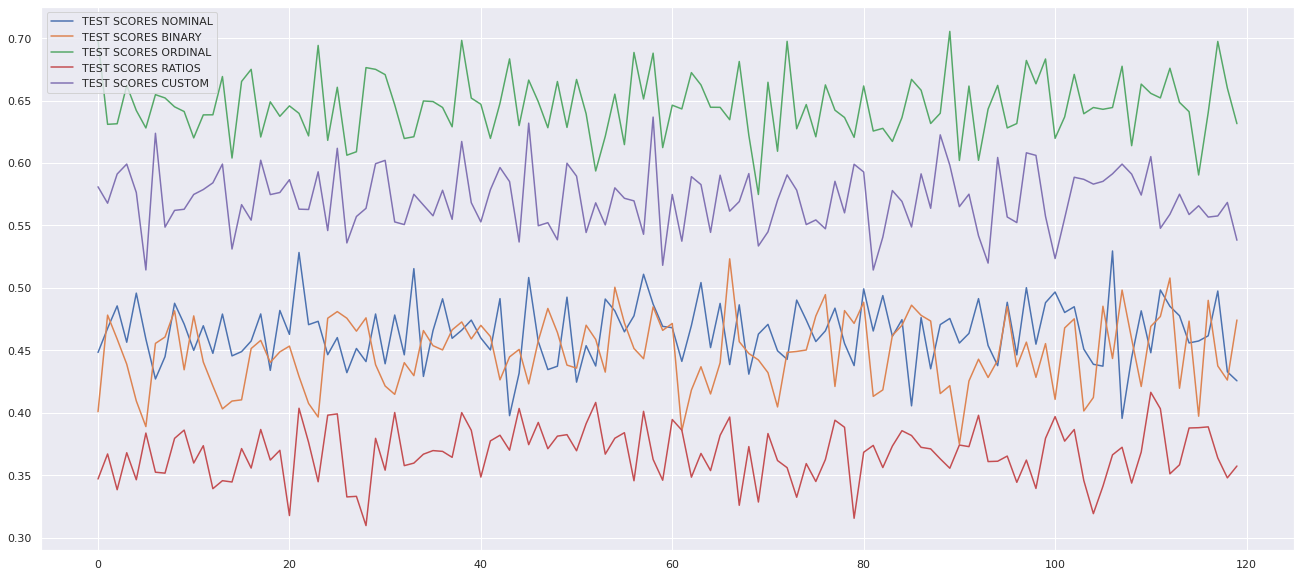

In [2]:
cl_weight = sklearn.utils.compute_class_weight(class_weight='balanced',classes=[0,1,2],y=raw_data.target)
cls_weight = {x:cl_weight[x] for x in range(3)}
N_JOBS=12
clf = BalancedRandomForestClassifier(n_jobs=N_JOBS,max_depth=5,warm_start=True)
REPEAT=12
with parallel_backend('multiprocessing'):
    disp = plt.figure(figsize=(20,10))
    transformed_bin_scores = cross_validate(clf,nominal_data,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=REPEAT,random_state=30), scoring='f1_macro', return_train_score=True,n_jobs=N_JOBS)
    disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores NOMINAL'.upper())
    transformed_bin_scores = cross_validate(clf,binary_data,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=REPEAT,random_state=30), scoring='f1_macro', return_train_score=True,n_jobs=N_JOBS)
    disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores BINARY'.upper())
    transformed_bin_scores = cross_validate(clf,ordinal_data,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=REPEAT,random_state=30), scoring='f1_macro', return_train_score=True,n_jobs=N_JOBS)
    disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores ORDINAL'.upper())
    transformed_bin_scores = cross_validate(clf,ratios_data,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=REPEAT,random_state=30), scoring='f1_macro', return_train_score=True,n_jobs=N_JOBS)
    disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores RATIOS'.upper())
    custom_cols = ['bin_literal','binary_sum','ord_norm']
    custom_data = raw_data.loc[:,custom_cols]
    transformed_bin_scores = cross_validate(clf,custom_data,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=REPEAT,random_state=30), scoring='f1_macro', return_train_score=True,n_jobs=N_JOBS)
    disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores CUSTOM'.upper())
    # disp = plt.plot(transformed_bin_scores['train_score'],label='Train Scores 2')
    s  = plt.legend()

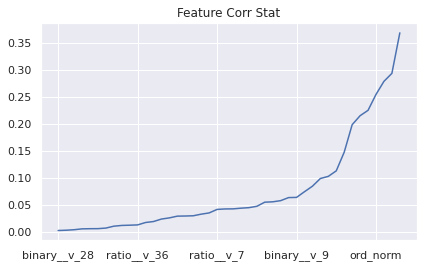

In [3]:
disp = raw_data.corrwith(raw_data.target, method='pearson').abs().sort_values().iloc[:-1].plot(title="Feature Corr Stat")

In [2]:
from prince import MCA,FAMD,MFA
X_combined = pd.concat([raw_data_ohe.loc[:,raw_data_ohe_eval.columns],raw_data_ohe_eval],ignore_index=True,axis=0)
X_train_data = raw_data_ohe.loc[:,raw_data_ohe_eval.columns]
def optimal_components(mca,pca=None):
    mca_i = 0
    result = {}
    
    col_masses = mca.col_masses_.sort_values(ascending=False)
    for i in range(3,len(col_masses)):
        if col_masses.iloc[:i].sum()/col_masses.sum() > 0.99:
            print(i)
            mca_i=i
            break
    result[mca.__class__.__name__] = mca_i
    # 630

    #510
    if type(pca) == sklearn.decomposition._pca.PCA:
        pca_i = 0
        d = pca.explained_variance_ratio_
        for i in range(3,len(d)):
            if d[:i].sum()/d.sum() > 0.99:
                print(i)
                pca_i=i
                break
        result[pca.__class__.__name__] = pca_i
    
#     result = {}
    return result
# print(optimal_components(mca,pca=pca))
# print(optimal_components(mca_train,pca=pca_train))
def categorise(df):
    categorical_data = df.loc[:,ordinal+nominal]
    df.loc[:,ordinal+nominal] = categorical_data.astype('object')
    df.loc[:,binary] = df.loc[:,binary].astype(np.float64)
    return df

pca = PCA(svd_solver='full')
category_pca = pca.fit_transform(X_combined.loc[:,nominal_ohe+ordinal_ohe])

In [3]:
pca_i = 0
d = pca.explained_variance_ratio_
for i in range(3,len(d)):
    if d[:i].sum()/d.sum() > 0.99:
        print(i)
        pca_i=i
        break

553


In [ ]:
"""
PCA - For Data
"""
X = raw_data_ohe.loc[:,raw_data_ohe_eval.columns]
# kernel_pca = make_pipeline(KernelPCA(kernel='cosine',random_state=42,eigen_solver='dense',n_jobs=-1,fit_inverse_transform=False))
kernel_pca = PCA(svd_solver='full')

"""
ColumnTransformer
"""
trf = ColumnTransformer([
    ('pca_binary',kernel_pca,nominal_ohe+ordinal_ohe+binary),
    ('pca_discrete',kernel_pca,ordinal+['bin_literal','ord_norm','binary_sum']),
    ('stdscl',make_pipeline(StandardScaler(),kernel_pca),make_column_selector(pattern='ratio__*'))
],sparse_threshold=0, remainder='passthrough',n_jobs=-1)


"""
Model
"""
model = LogisticRegressionCV(class_weight='balanced',fit_intercept=True,multi_class='ovr',max_iter=10000,random_state=42,n_jobs=-1,cv=RepeatedStratifiedKFold(n_splits=2,n_repeats=2,random_state=30),scoring='f1_macro',solver='lbfgs',Cs=100)


"""
Final PipeLine
"""
# clf = make_imb_pipeline(under_sampler,over_sampler,trf,model,memory=Memory(DATA_SAVE_PATH,verbose=0))
clf = make_imb_pipeline(trf,model)
# clf = make_imb_pipeline(trf,model,memory=Memory(DATA_SAVE_PATH,verbose=0))
with parallel_backend('loky'):
    transformed_bin_scores = cross_validate(clf,X,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=2,random_state=30), scoring='f1_macro', return_train_score=True,n_jobs=-1)
    disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores'.upper())

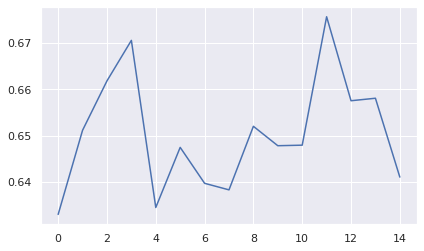

In [129]:
mca_comp =  MCA(n_components=610,benzecri=False,random_state=42,n_iter=20).fit_transform(pd.get_dummies(raw_data.loc[:,nominal+ordinal],columns=nominal+ordinal))
X = pd.concat([raw_data.loc[:,binary+ratios+['bin_literal','ord_norm','binary_sum']],mca_comp],axis=1,ignore_index=True)
with parallel_backend('loky'):
    clf = LogisticRegressionCV(class_weight='balanced',n_jobs=-1,random_state=42,cv=StratifiedKFold(n_splits=3),multi_class='ovr',max_iter=10000)
    transformed_bin_scores = cross_validate(clf,X,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=5,random_state=30), scoring='f1_macro', return_train_score=True,n_jobs=24)
    disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores NOMINAL'.upper())

#### COV estimation

In [6]:
# X= raw_data.drop(['target'],axis=1)
X_raw = raw_data.loc[:,nominal+ordinal+binary+['bin_literal','ord_norm','binary_sum']+ratios]
X = pd.concat([raw_data.loc[:,raw_data_eval.columns],raw_data_eval],ignore_index=True,axis=0)
from joblib import Parallel
X_eval = raw_data_eval
cov_estimators = [EmpiricalCovariance(),MinCovDet(),MinCovDet(),OAS(),LedoitWolf(),ShrunkCovariance()]
with parallel_backend('threading',n_jobs=-1):
    fitted_cov_estimators = [x.fit(X) for x in cov_estimators]
    

cov_scores_eval = [x.score(X_eval) for x in fitted_cov_estimators]
cov_matrices  = [pd.DataFrame(est.covariance_, columns=est.feature_names_in_,index = est.feature_names_in_)
                for est in cov_estimators]


import copy
T = 0.7
pos_variable_f = [{c:[] for c in X.columns} for _ in range(len(cov_matrices))]
neg_variable_f = [{c:[] for c in X.columns} for _ in range(len(cov_matrices))]
for idx,C in enumerate(cov_matrices):
    cols = list(C.columns)
    for f in cols:
        # not_same_f = cols.remove('f')
        not_same_f = copy.deepcopy(cols)
        not_same_f.remove(f)
        cov_f = C[f].loc[not_same_f]
        pos_imp_co_f = cov_f[cov_f>T]
        neg_imp_co_f = cov_f[cov_f<-T]
        pos_variable_f[idx][f].extend(list(pos_imp_co_f.index))
        neg_variable_f[idx][f].extend(list(neg_imp_co_f.index))
pos_variable_f = [{prel_key:prel[prel_key] for prel_key in prel if len(prel[prel_key])!=0} for prel in pos_variable_f]
neg_variable_f = [{nrel_key:nrel[nrel_key] for nrel_key in nrel if len(nrel[nrel_key])!=0} for nrel in neg_variable_f]


prel_coll = [set() for _ in range(len(cov_matrices))]
nrel_coll = [set() for _ in range(len(cov_matrices))]
for idx,rel in enumerate(pos_variable_f):
    for features in rel.values():
        for f in features:
            prel_coll[idx].add(f)
    for feature in rel.keys():
        # for f in features:
        prel_coll[idx].add(feature)
for idx,rel in enumerate(neg_variable_f):
    for features in rel.values():
        for f in features:
            nrel_coll[idx].add(f)
    for feature in rel.keys():
        # for f in features:
        nrel_coll[idx].add(feature)

nrel_coll = [list(L) for L in nrel_coll]
prel_coll = [list(L) for L in prel_coll]
high_variable_f = [list(set(prel_coll[idx]+nrel_coll[idx])) for idx in range(len(cov_matrices))]
total_feature_set = set(raw_data.drop(['target'],axis=1).columns)
low_variable_f = [list(total_feature_set-set(high_f)) for high_f in high_variable_f]


In [4]:
[len(f) for f in high_variable_f]

[31, 23, 22, 31, 31, 31]

In [9]:
master_scores_nrel = []
FOLDS = dict(n_splits=2,n_repeats=5)
with parallel_backend('loky'):
    for idx in range(len(prel_coll)):
        X = raw_data.loc[:,nrel_coll[idx]]
        y = raw_data.target
        model = DecisionTreeClassifier(random_state=42, class_weight='balanced',max_depth=5)
        clf = OneVsOneClassifier(model,n_jobs=-1)
        scores = cross_validate(clf,X,y,cv=RepeatedStratifiedKFold(**FOLDS),n_jobs=-1,scoring='f1_macro',return_train_score=True)
        master_scores_nrel.append({'test_score':scores['test_score'].mean(),'train_score':scores['train_score'].mean()})
master_scores_nrel

[{'test_score': 0.5785924277327665, 'train_score': 0.6585453999147463},
 {'test_score': 0.6075286090934575, 'train_score': 0.6794388477920188},
 {'test_score': 0.5782064226677488, 'train_score': 0.654807326822232},
 {'test_score': 0.5831022220184742, 'train_score': 0.655472489087965},
 {'test_score': 0.5801730932164297, 'train_score': 0.6581740881141818},
 {'test_score': 0.5841307230476508, 'train_score': 0.6559378978490297}]

In [10]:
master_scores_prel = []
with parallel_backend('loky'):
    for idx in range(len(prel_coll)):
        X = raw_data.loc[:,prel_coll[idx]]
        y = raw_data.target
        model = DecisionTreeClassifier(random_state=42, class_weight='balanced',max_depth=5)
        clf = OneVsRestClassifier(model,n_jobs=-1)
        scores = cross_validate(clf,X,y,cv=RepeatedStratifiedKFold(**FOLDS),n_jobs=-1,scoring='f1_macro',return_train_score=True)
        master_scores_prel.append({'test_score':scores['test_score'].mean(),'train_score':scores['train_score'].mean()})

master_scores_prel

[{'test_score': 0.6158924254097731, 'train_score': 0.709544429319378},
 {'test_score': 0.6099294365521402, 'train_score': 0.6954426252028738},
 {'test_score': 0.6114344325706644, 'train_score': 0.706066164325669},
 {'test_score': 0.6136891697492197, 'train_score': 0.709922058177043},
 {'test_score': 0.6184138450953212, 'train_score': 0.7064879738600393},
 {'test_score': 0.6145486614585046, 'train_score': 0.7091222842760403}]

In [6]:
from tqdm import trange,tqdm
master_scores = []
with parallel_backend('loky'):
    for idx in trange(len(prel_coll)):
        X = raw_data.loc[:,high_variable_f[idx]]
        y = raw_data.target
        mask = gen_categorical_mask(X)
        
        # model = HistGradientBoostingClassifier(random_state=42,categorical_features=mask,min_samples_leaf=3,max_leaf_nodes=3,max_iter=100, learning_rate=0.12)
        # clf = OneVsOneClassifier(model,n_jobs=-1)
        model = HistGradientBoostingClassifier(random_state=42,categorical_features=mask,)
        # model = DecisionTreeClassifier(random_state=42, class_weight='balanced',max_depth=5)
        # clf = OneVsRestClassifier(model,n_jobs=-1)
        model = LogisticRegressionCV(class_weight='balanced',fit_intercept=False,multi_class='ovr',max_iter=10000,random_state=42,l1_ratios=np.linspace(0.0,1.0,num=5), penalty='elasticnet',solver='saga')
        # model = LogisticRegressionCV(class_weight='balanced',fit_intercept=False,multi_class='ovr',max_iter=10000,random_state=42,penalty='elasticnet',solver='saga',cv=StratifiedKFold(n_splits=2),n_jobs=-1,l1_ratios=np.linspace(0.0,1.0,num=5))
        model = LogisticRegressionCV(class_weight='balanced',fit_intercept=False,multi_class='ovr',max_iter=100000,random_state=42,n_jobs=-1,cv=StratifiedKFold(n_splits=2),scoring='f1_macro',solver='lbfgs',Cs=10)
        LG_clf = model
        scores = cross_validate(LG_clf,X,y,cv=RepeatedStratifiedKFold(n_splits=2,n_repeats=1),n_jobs=-1,scoring='f1_macro',return_train_score=True,return_estimator=True)
        master_scores.append({'test_score':scores['test_score'].mean(),'train_score':scores['train_score'].mean()})

master_scores

100%|██████████| 6/6 [01:18<00:00, 13.04s/it]


[{'test_score': 0.6678181038259231, 'train_score': 0.6840862909290428},
 {'test_score': 0.6472813173069205, 'train_score': 0.6608969842301045},
 {'test_score': 0.6655398417724618, 'train_score': 0.6849681512779444},
 {'test_score': 0.6603110142107707, 'train_score': 0.6885441346242575},
 {'test_score': 0.6623035981011279, 'train_score': 0.6895983020158845},
 {'test_score': 0.6691395302287038, 'train_score': 0.6807327407267107}]

In [19]:
sfs_estimator = LogisticRegression(class_weight='balanced',multi_class='ovr',solver='lbfgs',max_iter=10000,fit_intercept=False,random_state=42,n_jobs=-1,tol=0.000001,)
sfs = SequentialFeatureSelector(estimator=sfs_estimator,n_features_to_select='auto',tol=0.001,scoring='f1_macro',n_jobs=-1,direction='backward',cv=StratifiedKFold(n_splits=2))
rfecv = RFECV(sfs_estimator,cv=StratifiedKFold(n_splits=2),scoring='f1_macro',n_jobs=-1,)

Started Fitting Transformer
Started training classifier
              precision    recall  f1-score   support

           0       0.81      0.69      0.74       249
           1       0.83      0.78      0.80       373
           2       0.45      0.63      0.52       138

    accuracy                           0.73       760
   macro avg       0.69      0.70      0.69       760
weighted avg       0.75      0.72      0.73       760



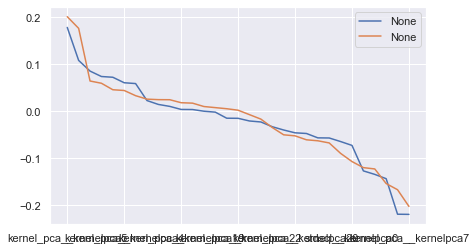

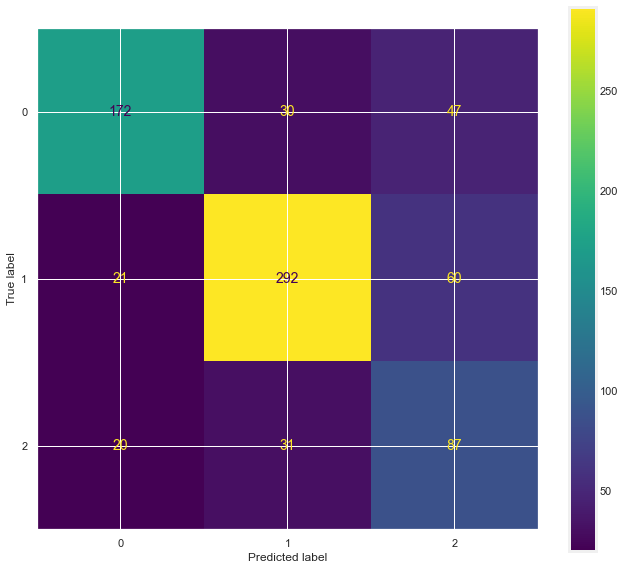

In [12]:
"""
Training Set Generation
"""
X = raw_data.loc[:,high_variable_f[3]]
y = raw_data.target
X_train, X_test, y_train, y_test = gen_train_test(X,y, 0.2)
# X_train, X_valid, y_train, y_valid = gen_train_test(X_train,y_train, 0.5)

"""
Column Selectors
"""
ordinal_cols = make_column_selector(pattern='ordinal__*')
nominal_cols = make_column_selector(pattern='nominal__*')
binary_cols  = make_column_selector(pattern='binary__*')
kpca_cols  = make_column_selector(pattern='binary__*|nominal__*|ordinal__*|bin_*|ord_*')


"""
Prep
"""
nominal_master = pd.concat([nominal_data, nominal_data_eval],axis=0)
ordinal_master = pd.concat([ordinal_data, ordinal_data_eval],axis=0)


def nominal_categories(X):
    ct = make_column_transformer((OneHotEncoder(sparse=False),nominal),sparse_threshold=0,remainder='drop')
    ct.fit(nominal_master.astype('int'))
    results = ct.named_transformers_['onehotencoder'].categories_
    category_db = {x:Categs for x, Categs in zip(nominal,results)}
    tmp =  make_column_transformer(('passthrough',nominal_cols),sparse_threshold=0,remainder='drop')
    tmp.fit(X.astype('int'))
    selected_features = [x.replace('passthrough__',"") for x in tmp.get_feature_names_out()]
    unique_categories_nom = [category_db[f] for f in selected_features]
    return unique_categories_nom


def ordinal_categories(X):
    ct = make_column_transformer((OneHotEncoder(sparse=False),ordinal),sparse_threshold=0,remainder='drop')
    ct.fit(ordinal_master)
    results = ct.named_transformers_['onehotencoder'].categories_
    category_db = {x:Categs for x, Categs in zip(ordinal,results)}
    tmp =  make_column_transformer(('passthrough',ordinal_cols),sparse_threshold=0,remainder='drop')
    tmp.fit(X)
    selected_features = [x.replace('passthrough__',"") for x in tmp.get_feature_names_out()]
    unique_categories_ord = [category_db[f] for f in selected_features]
    return unique_categories_ord


def nominal_value_counts():
    df = nominal_master.astype('int')
    df_c = {}
    for c in df.columns:
        df_c[c] = df[c].value_counts()
    return df_c


def ordinal_value_counts():
    df = ordinal_master
    df_c = {}
    for c in df.columns:
        df_c[c] = df[c].value_counts()
    return df_c


"""
MCA - For Categorical Data
"""
kernel_pca = make_pipeline(KernelPCA(kernel='cosine',random_state=42,eigen_solver='dense',n_jobs=-1,fit_inverse_transform=False))

"""
Samplers
"""
sampler_estimator = DecisionTreeClassifier(random_state=10, class_weight='balanced')
under_sampler = InstanceHardnessThreshold(random_state=42,estimator=sampler_estimator,cv=5,n_jobs=-1)
over_sampler_sampler = RandomOverSampler(random_state=42)


"""
ColumnTransformer
"""
trf = ColumnTransformer([
    ('kernel_pca',kernel_pca,kpca_cols),
    ('stdscl',make_pipeline(StandardScaler(),kernel_pca),make_column_selector(pattern='ratio__*'))
],sparse_threshold=0, remainder='passthrough',n_jobs=-1)


"""
Model
"""
model = LogisticRegressionCV(class_weight='balanced',fit_intercept=True,multi_class='ovr',max_iter=10000,random_state=42,n_jobs=-1,cv=RepeatedStratifiedKFold(n_splits=5),scoring='f1_macro',solver='lbfgs',Cs=100)


"""
Final PipeLine
"""
# clf = make_imb_pipeline(under_sampler,over_sampler,trf,model,memory=Memory(DATA_SAVE_PATH,verbose=0))
clf = make_imb_pipeline(trf,OneVsOneClassifier(model,n_jobs=-1),memory=Memory(DATA_SAVE_PATH,verbose=0))


"""
Execution
"""
def execute():
    with parallel_backend('loky'):

        print("Started Fitting Transformer")
        with parallel_backend('loky'):
            X_train_enc = trf.fit_transform(X_train,y_train)
            X_test_enc = trf.transform(X_test)
            # X_train_enc

            X_train_df = pd.DataFrame(X_train_enc,columns=trf.get_feature_names_out(),index=X_train.index)
            X_test_df = pd.DataFrame(X_test_enc,columns=trf.get_feature_names_out(),index=X_test.index)

            X_train_df.corrwith(raw_data.target.loc[X_train.index]).sort_values(ascending=False).plot()
            X_test_df.corrwith(raw_data.target.loc[X_test.index]).sort_values(ascending=False).plot()
            disp = plt.legend()

        print("Started training classifier")
        y_pred = clf.fit(X_train,y_train).predict(X_test)
    return y_pred

"""
Plotting
"""
def report_model(y_test,y_pred):
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.style.use('fivethirtyeight')
    disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,ax=ax)
    # scores = cr(clf,X,y,cv=RepeatedStratifiedKFold(**FOLDS),n_jobs=-1,scoring='f1_macro',return_train_score=True)

    print(classification_report(y_test,y_pred))
y_pred=execute()
report_model(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.82      0.65      0.72       249
           1       0.81      0.79      0.80       373
           2       0.46      0.65      0.54       138

    accuracy                           0.72       760
   macro avg       0.69      0.70      0.69       760
weighted avg       0.75      0.72      0.73       760



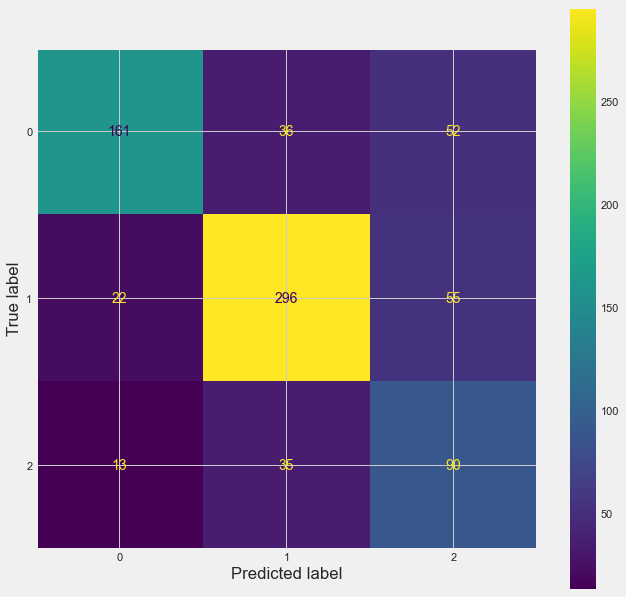

In [21]:
X = raw_data.loc[:,high_variable_f[3]]
y = raw_data.target
X_train, X_test, y_train, y_test = gen_train_test(X,y, 0.2)
model = SVC(probability=True,class_weight='balanced',kernel='linear',random_state=42,break_ties=True,tol=0.0001,gamma='auto',shrinking=False,decision_function_shape='ovr',C=125.71428571428572)
model = SVC(probability=True,class_weight='balanced',kernel='linear',random_state=42,break_ties=False,tol=1e-08,gamma='auto',shrinking=False,decision_function_shape='ovo',C=221.42857142857144)

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV,HalvingRandomSearchCV

with parallel_backend('loky'):
    X_train_enc = trf.fit_transform(X_train,y_train)
    X_test_enc = trf.transform(X_test)
    # fit_transform
    clf = Pipeline([
        ('prep',trf),
        ('svc',model)
    ],memory=Memory(DATA_SAVE_PATH,verbose=0))
    param_distributions = {
        'svc__tol': [10**(-x) for x in range(3,9)],
        'svc__C': np.linspace(150,250,num=50),
    }
    model_search = HalvingRandomSearchCV(clf,param_distributions=param_distributions,scoring='f1_macro',random_state=42,return_train_score=True,n_jobs=-1,verbose=1,factor=2,cv=RepeatedStratifiedKFold(n_splits=2))
    # model_search.fit(X,y)
    y_pred = clf.fit(X_train,y_train).predict(X_test)
    report_model(y_test,y_pred)

In [22]:
# best_clfs = [best_clf_lgcv,best_clf_svc]
import shelve
with shelve.open('../models/best_clfs.db') as mdb:
    # best_clf_lgcv = mdb['LogisticRegressionCV_KernelPCA.model']
    # best_clf_svc = mdb['SVC_Linear_KernelPCA.model']
    clf_ovo_lgcv = mdb['OVO_LogisticRegressionCV_KernelPCA.model']
    

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       249
           1       0.75      0.90      0.82       373
           2       0.52      0.27      0.35       138

    accuracy                           0.72       760
   macro avg       0.67      0.63      0.63       760
weighted avg       0.70      0.72      0.70       760



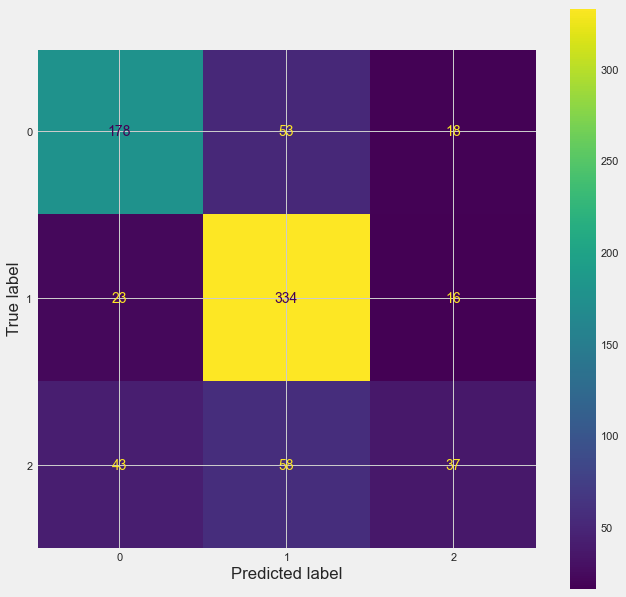

In [23]:
with open('../models/clf_hist_ord_nom_cat','rb') as fp:
    tm_clf = pickle.load(fp)
clf_hist = Pipeline([
        ('prep',trf),
        ('hist',tm_clf[1])
    ],memory=Memory(DATA_SAVE_PATH,verbose=0))
y_pred = tm_clf.fit(X_train,y_train).predict(X_test)
report_model(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.76      0.71      0.74       621
           1       0.78      0.82      0.80       932
           2       0.45      0.43      0.44       345

    accuracy                           0.71      1898
   macro avg       0.66      0.65      0.66      1898
weighted avg       0.71      0.71      0.71      1898



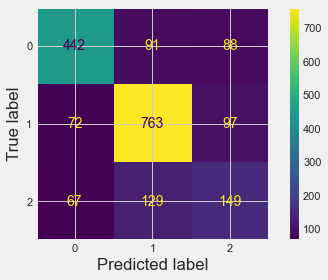

In [24]:
# model.decision_function(X)
X = raw_data.loc[:,high_variable_f[3]]
X_eval = raw_data_eval.loc[:,high_variable_f[3]]
y = raw_data.target
model = LogisticRegressionCV(class_weight='balanced',fit_intercept=False,multi_class='ovr',max_iter=100000,random_state=42,n_jobs=-1,cv=RepeatedStratifiedKFold(n_splits=5,random_state=42),scoring='f1_macro',solver='liblinear',Cs=100,)
clf = make_pipeline(trf,OneVsOneClassifier(model,n_jobs=-1),memory=CACHE_)
with parallel_backend('loky'):
    clf.fit(X,y)

X_train, X_test, y_train, y_test = gen_train_test(X,y, 0.5)
y_pred = clf.fit(X_train,y_train).predict(X_test)
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,)
print(classification_report(y_test,y_pred))
# prob = clf.predict_proba(X_eval)
# LG_eval_prob: pd.DataFrame = pd.DataFrame(prob,columns=['Class '+str(i) for i in range(3)],index=raw_data_eval.index)
# LG_eval_prob.sort_values(by='Class 2',ascending=False, inplace=True)
# LG_eval_prob[LG_eval_prob['Class 2']>0.9].index

In [25]:
# low_variable_f = []
# total_feature_set = set(raw_data.drop(['target'],axis=1).columns)
# low_variable_f = [list(total_feature_set-set(high_f)) for high_f in high_variable_f]
low_var_master_scores = []
# FOLDS=()
with parallel_backend('loky'):
    for idx in range(len(prel_coll)):
        X = raw_data.loc[:,low_variable_f[idx]]
        y = raw_data.target
        # mask = gen_categorical_mask(X)
        # model = HistGradientBoostingClassifier(random_state=42,categorical_features=mask,min_samples_leaf=3,max_leaf_nodes=3,max_iter=100, learning_rate=0.12)
        # clf = OneVsOneClassifier(model,n_jobs=-1)
        model = BalancedRandomForestClassifier(random_state=42, class_weight='balanced',max_depth=5)
        clf = model
        # clf = model
        scores = cross_validate(clf,X,y,cv=RepeatedStratifiedKFold(),n_jobs=-1,scoring='f1_macro',return_train_score=True)
        low_var_master_scores.append({'test_score':scores['test_score'].mean(),'train_score':scores['train_score'].mean()})

low_var_master_scores

[{'test_score': 0.1206778596661124, 'train_score': 0.14917723332176883},
 {'test_score': 0.34377545867982656, 'train_score': 0.3677684314513303},
 {'test_score': 0.12022904331976329, 'train_score': 0.14781795895243827},
 {'test_score': 0.12144305220724286, 'train_score': 0.14686744806835295},
 {'test_score': 0.12217869411278032, 'train_score': 0.14706872543714972},
 {'test_score': 0.1199737730968645, 'train_score': 0.1470867844716809}]

In [18]:

low_var_f  = low_variable_f[3]
high_var_f = high_variable_f[3]
all_f      = list(raw_data_eval.columns)
X_low  = raw_data.loc[:,low_var_f]
X_high = raw_data.loc[:,high_var_f]
X_all  = raw_data.loc[:,all_f]
y      = raw_data.target


nominal_master = pd.concat([nominal_data, nominal_data_eval],axis=0)
ordinal_master = pd.concat([ordinal_data, ordinal_data_eval],axis=0)
ordinal_cols = make_column_selector(pattern='ordinal__*')
nominal_cols = make_column_selector(pattern='nominal__*')

def nominal_categories(X):
    ct = make_column_transformer((OneHotEncoder(sparse=False),nominal),sparse_threshold=0,remainder='drop')
    ct.fit(nominal_master.astype('int'))
    results = ct.named_transformers_['onehotencoder'].categories_
    category_db = {x:Categs for x, Categs in zip(nominal,results)}
    tmp =  make_column_transformer(('passthrough',nominal_cols),sparse_threshold=0,remainder='drop')
    tmp.fit(X.astype('int'))
    selected_features = [x.replace('passthrough__',"") for x in tmp.get_feature_names_out()]
    unique_categories_nom = [category_db[f] for f in selected_features]
    return unique_categories_nom


def ordinal_categories(X):
    ct = make_column_transformer((OneHotEncoder(sparse=False),ordinal),sparse_threshold=0,remainder='drop')
    ct.fit(ordinal_master)
    results = ct.named_transformers_['onehotencoder'].categories_
    category_db = {x:Categs for x, Categs in zip(ordinal,results)}
    tmp =  make_column_transformer(('passthrough',ordinal_cols),sparse_threshold=0,remainder='drop')
    tmp.fit(X)
    selected_features = [x.replace('passthrough__',"") for x in tmp.get_feature_names_out()]
    unique_categories_ord = [category_db[f] for f in selected_features]
    return unique_categories_ord


ohe_data = pd.get_dummies(X.loc[:,nominal].astype('int'),columns=nominal,drop_first=True)
# ohe_data

# ohe_pca_x = PCA(n_components='mle',random_state=42).fit_transform(ohe_data,y)
ohe_nom = OneHotEncoder(categories=nominal_categories(X_all),sparse=False)
ohe_ord = OneHotEncoder(categories=ordinal_categories(X_all),sparse=False)
poly_features  = PolynomialFeatures(interaction_only=True,degree=2,include_bias=False)

pca = PCA(random_state=42,svd_solver='full')
kernel_pca = KernelPCA(kernel='cosine',eigen_solver='dense',random_state=42,n_jobs=24)
ct = make_column_transformer((ohe_nom,nominal_cols),(ohe_ord,ordinal_cols),('passthrough',ordinal_cols),remainder='passthrough',n_jobs=-1)
## Need to implement feature_selection
ohe_pca = make_pipeline(ct,StandardScaler(),pca,poly_features)
ohe_kernel_pca = make_pipeline(ct,StandardScaler(),kernel_pca,poly_features)

with parallel_backend('threading'):
    ohe_kernel_pca_x = ohe_kernel_pca.fit_transform(X_all)
    ohe_pca_x = ohe_pca.fit_transform(X_all)
#     ohe_kernel_pca.fit(X_all,y)
#     ohe_pca.fit(X_all,y)
df1 = pd.DataFrame(ohe_pca_x,columns=ohe_pca[-1].get_feature_names_out())
df2 = pd.DataFrame(ohe_kernel_pca_x,columns=ohe_kernel_pca[-1].get_feature_names_out())

import shelve
import gc
# with shelve.open('../data/poly_features.db',protocol=pickle.HIGHEST_PROTOCOL) as poly_db:
#     poly_db['PCA__Poly'] = df1    
#     del df1, ohe_pca_x
# gc.collect()
    
# with shelve.open('../data/poly_features.db') as poly_db:
#     kernel_poly_db['KernelPCA__Poly'] = df2
#     del df2, ohe_kernel_pca_x
# gc.collect()

    

ValueError: Shape of passed values is (3796, 444153), indices imply (3796, 540280)

In [9]:
gc.collect()


0

In [ ]:
poly_features  = PolynomialFeatures(interaction_only=True,degree=2,include_bias=False)
poly_X = poly_features.fit_transform(X)
pca_X = PCA(svd_solver='full',random_state=42).fit_transform(poly_X)
mutual_info = mutual_info_classif(pca_X,y,n_neighbors=5,random_state=42)
result = pd.DataFrame(mutual_info,index=poly_features.get_feature_names_out(),columns=['mic']).sort_values(by='mic',ascending=False)
input_features = list(X.columns)
f_mask = [(x in input_features) for x in poly_features.get_feature_names_out()]
mask   = pd.Series(f_mask,index=poly_features.get_feature_names_out())
result['is_input'] = mask
results.append(result)

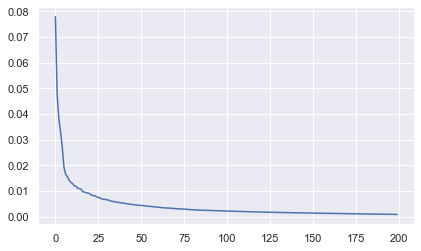

In [38]:
pca = ohe_pca[-1]
pca.singular_values_
plt.plot()
plt.plot(pca.explained_variance_ratio_)

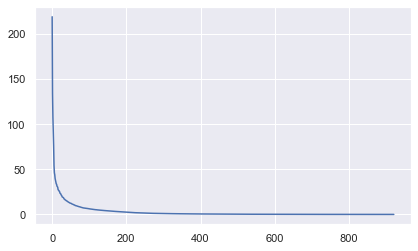

In [46]:
pca = ohe_kernel_pca[-1]
# pca.singular_values_
# plt.plot()
plt.plot(pca.eigenvalues_)